# KSP RocketPy
## What is this?
A handy notebook for teams to use in running basic rocketpy simulations.

Much of it is based on the [rocketpy readme](https://github.com/Projeto-Jupiter/RocketPy#readme), and the [user guide](https://docs.rocketpy.org/en/latest/notebooks/getting_started.html).

Currently in development to switch from simulating the Callisto rocket (for which rocketpy was devloped) to nebula in preparation for the first launch.

## Using KSP RocketPy
Simply import the module folder and required classes

In [2]:
from rocketpy import Environment, Rocket, SolidMotor, Flight

## Help Text
To access the documentation directly, use the inbuilt help python function.

In [2]:
help(Rocket.addFins)

Help on function addFins in module rocketpy.Rocket:

addFins(self, n, span, rootChord, tipChord, distanceToCM, radius=0, cantAngle=0, airfoil=None)
    Create a fin set, storing its parameters as part of the
    aerodynamicSurfaces list. Its parameters are the axial position
    along the rocket and its derivative of the coefficient of lift
    in respect to angle of attack.
    
    Parameters
    ----------
    n : int
        Number of fins, from 2 to infinity.
    span : int, float
        Fin span in meters.
    rootChord : int, float
        Fin root chord in meters.
    tipChord : int, float
        Fin tip chord in meters.
    distanceToCM : int, float
        Fin set position relative to rocket unloaded center of
        mass, considering positive direction from center of mass to
        nose cone. Consider the center point belonging to the top
        of the fins to calculate distance.
    radius : int, float, optional
        Reference radius to calculate lift coefficient. I

## Basic Simulation Runthrough

### Setup an environment for the simulation
This includes the date, time, weather data, launch site coordinates and launch rail length. The current pad used is [here](https://goo.gl/maps/2g3hUcQDZmZLK47N6) on the Machrihanish Range.

In [5]:
from datetime import date

today = date.today()

Env = Environment(
    railLength=4,
    latitude=55.433159,
    longitude=-5.680270,
    elevation=40,
    date=(today.year, today.month, today.day, 12) # Launch today at 12:00
) 

We can then create an atmospheric model for use in our flight simulation

Launch Site Details

Launch Rail Length: 4  m
Launch Date: 2022-05-27 12:00:00 UTC
Launch Site Latitude: 55.43316°
Launch Site Longitude: -5.68027°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 330421.07 W    6146261.83 N
Launch Site UTM zone: 30U
Launch Site Surface Elevation: 39.9 m


Atmospheric Model Details

Atmospheric Model Type: CustomAtmosphere
CustomAtmosphere Maximum Height: 1.600 km


Surface Atmospheric Conditions

Surface Wind Speed: 5.44 m/s
Surface Wind Direction: 287.12°
Surface Wind Heading: 107.12°
Surface Pressure: 1008.47 hPa
Surface Temperature: 300.00 K
Surface Air Density: 1.171 kg/m³
Surface Speed of Sound: 347.22 m/s


Atmospheric Model Plots


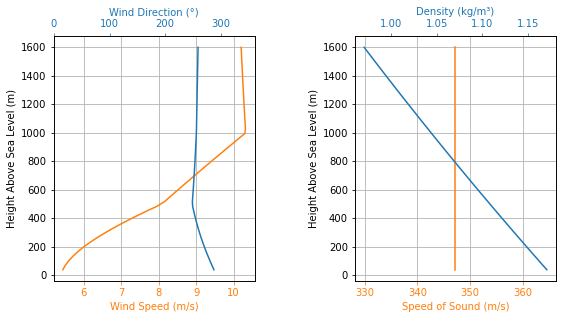

In [23]:
Env.setAtmosphericModel(
    type="CustomAtmosphere",
    pressure=None,
    temperature=300,
    wind_u=[(0, 5), (1000, 10)],
    wind_v=[(0, -2), (500, 3), (1600, 2)],
)
Env.info()

Alternativelt we can also get weather data from the [National Weather Service](https://nomads.ncep.noaa.gov/). Note that if the provided date for the environment is beyond the range of the forecasts, a `ValueError` is produced.

Launch Site Details

Launch Rail Length: 4  m
Launch Date: 2022-05-27 12:00:00 UTC
Launch Site Latitude: 55.43316°
Launch Site Longitude: -5.68027°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 330421.07 W    6146261.83 N
Launch Site UTM zone: 30U
Launch Site Surface Elevation: 39.9 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 80.258 km
Forecast Time Period: From  2022-05-27 06:00:00  to  2022-06-12 06:00:00  UTC
Forecast Hour Interval: 3  hrs
Forecast Latitude Range: From  -90.0 ° To  90.0 °
Forecast Longitude Range: From  0.0 ° To  359.75 °


Surface Atmospheric Conditions

Surface Wind Speed: 13.05 m/s
Surface Wind Direction: 291.64°
Surface Wind Heading: 111.64°
Surface Pressure: 1000.00 hPa
Surface Temperature: 282.04 K
Surface Air Density: 1.235 kg/m³
Surface Speed of Sound: 336.67 m/s


Atmospheric Model Plots


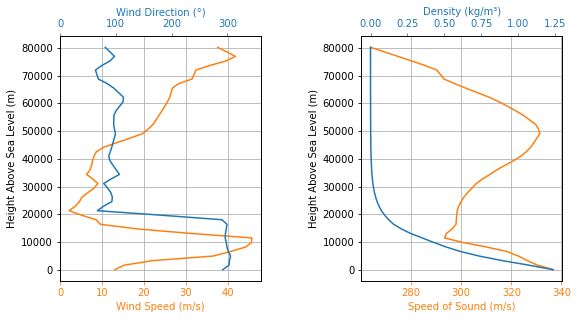

In [6]:
Env.setAtmosphericModel(type='Forecast', file='GFS')
Env.info()

### Setup a rocket motor
Currently only a solidrocket motor class is provided, with the [CTI 7450M2505-P](https://www.rocketreviews.com/cti-m2505-classic.html). Thrust curve is loaded form a `.eng` file.

In future we will build a *liquid engine* class implemented with a similar interface.

The motor used is the [Cesaroni M1450](https://www.thrustcurve.org/motors/Cesaroni/9955M1450-P/) as will be present on Nebula.

In [10]:
CesaroniM1450 = SolidMotor(
    thrustSource="data/motors/Cesaroni_9955M1450-P.eng",
    burnOut=6.9,
    grainNumber=5,
    interpolationMethod='linear'
)

### Setup the rocket itself
The parameters for the rocket motor, mass, drag profiles etc. (Note: this is not yet updated from Callisto)



In [11]:
Calisto = Rocket(
    motor=CesaroniM1450,
    radius=127/2000,
    mass=19.197-2.956,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag='data/calisto/powerOffDragCurve.csv',
    powerOnDrag='data/calisto/powerOnDragCurve.csv'
)

We also add rail buttons (small wheels connected to the launch rail to guide the rocket)

In [12]:
Calisto.setRailButtons([0.2, -0.5])

A nose cone, providing the distance to the center of mass and type. 
It is added to the list of aerodynamic surfaces used for simulation.

In [13]:
NoseCone = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)

Create fins, adding them to the list of aerodynamic surfaces

For nebula we have 4 equally spaced fins, of the design

In [14]:
FinSet = Calisto.addFins(4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956)

Add a tail/rocket diameter change

In [15]:
Tail = Calisto.addTail(topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656)

Inertia Details
Rocket Dry Mass: 16.241 kg (No Propellant)
Rocket Total Mass: 40.391 kg (With Propellant)

Geometrical Parameters
Rocket Radius: 0.0635 m

Aerodynamics Stability
Initial Static Margin: -0.945 c
Final Static Margin: 3.090 c

Aerodynamics Plots


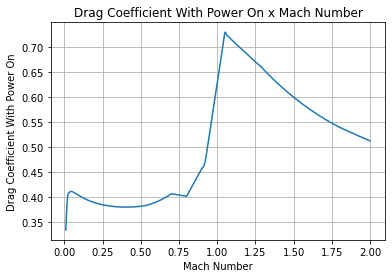

In [16]:
Calisto.info()

### Setup Recovery
Adding parachutes, including multiple stages

We can define triggers parachutes, in terms of functions using pressure and the rocket's state vector. For example we can define a trigger for the drogue and main parachute.

In [20]:
"""
Trigger functions are of type trigger(p,y) -> bool

where

p: pressure in pascal
y: state vector [x, y, z, vx, vy, vz, e0, e1, e2, e3, wx, wy, wz]
"""

def drogueTrigger(p, y):
    return False #y[5] < 0

def mainTrigger(p, y):
    return False #y[5] < 0 and y[2] < 800

We can then use these functions as triggers to add parachutes to the rocket.

In [21]:
Main = Calisto.addParachute('Main',
                            CdS=10.0,
                            trigger=mainTrigger, 
                            samplingRate=105,
                            lag=1.5,
                            noise=(0, 8.3, 0.5))

Drogue = Calisto.addParachute('Drogue',
                              CdS=1.0,
                              trigger=drogueTrigger, 
                              samplingRate=105,
                              lag=1.5,
                              noise=(0, 8.3, 0.5))

## Run Simulation
Instantiating the `Flight` class runs the simulation, and generates data required for analysis.

Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 39.87 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.999 | e1: -0.044 | e2: -0.000 | e3: 0.000
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Launch Rail Orientation

Launch Rail Inclination: 85.00°
Launch Rail Heading: 0.00°


Surface Wind Conditions

Frontal Surface Wind Speed: -1.60 m/s
Lateral Surface Wind Speed: -5.20 m/s


 Rail Departure State

Rail Departure Time: 0.408 s
Rail Departure Velocity: 15.194 m/s
Rail Departure Static Margin: -0.817 c
Rail Departure Angle of Attack: 19.548°
Rail Departure Thrust-Weight Ratio: 5.503
Rail Departure Reynolds Number: 1.310e+05


BurnOut State

BurnOut time: 6.870 s
Altitude at burnOut: 1109.969 m (AGL)
Rocket velocity at burnOut: 274.112 m/s
Freestream velocity at burnOut: 273.938 m/s
Mach Number at burnOut: 0.789
Kinetic energy at burnOut: 6.102e+05 J


Apogee


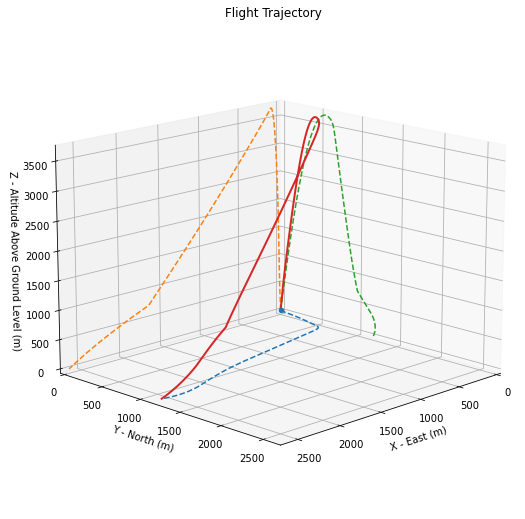



Trajectory Kinematic Plots



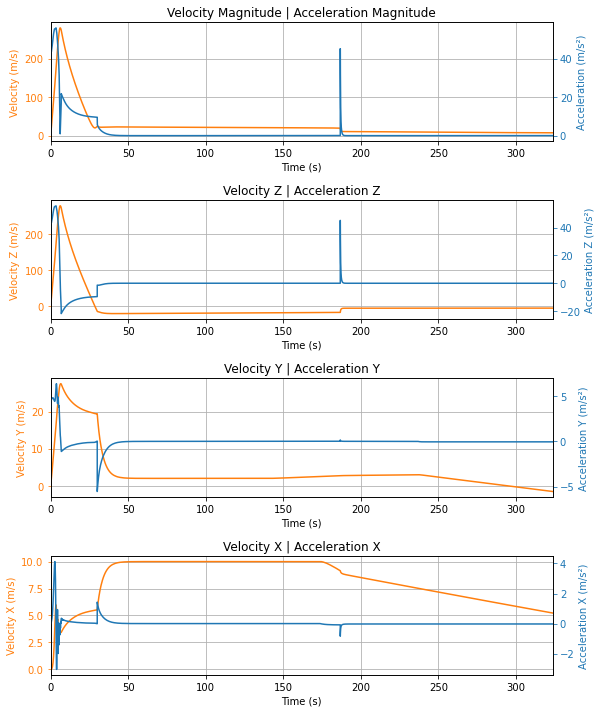



Angular Position Plots



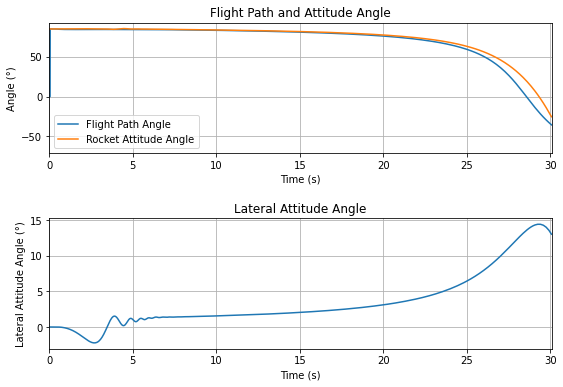



Path, Attitude and Lateral Attitude Angle plots



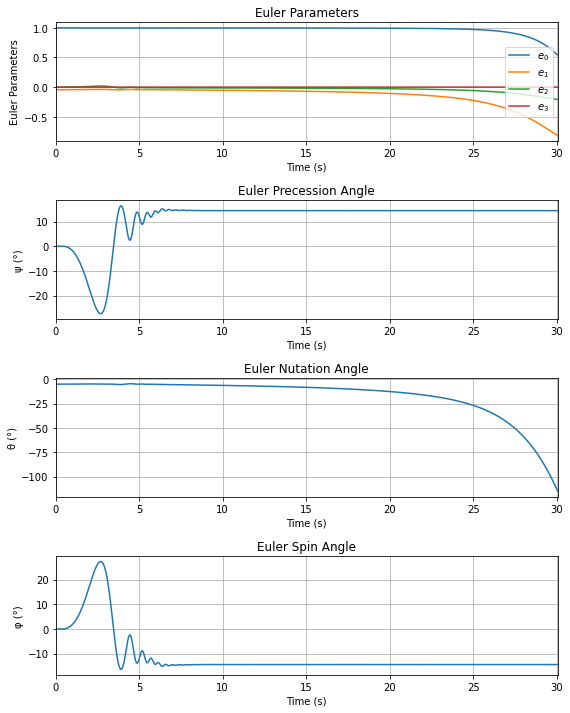



Trajectory Angular Velocity and Acceleration Plots



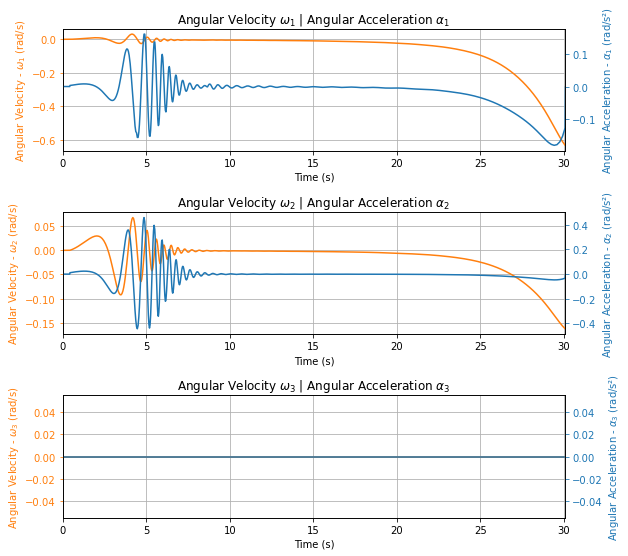



Trajectory Force Plots



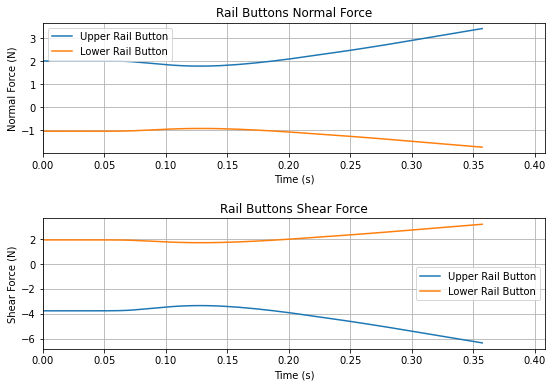

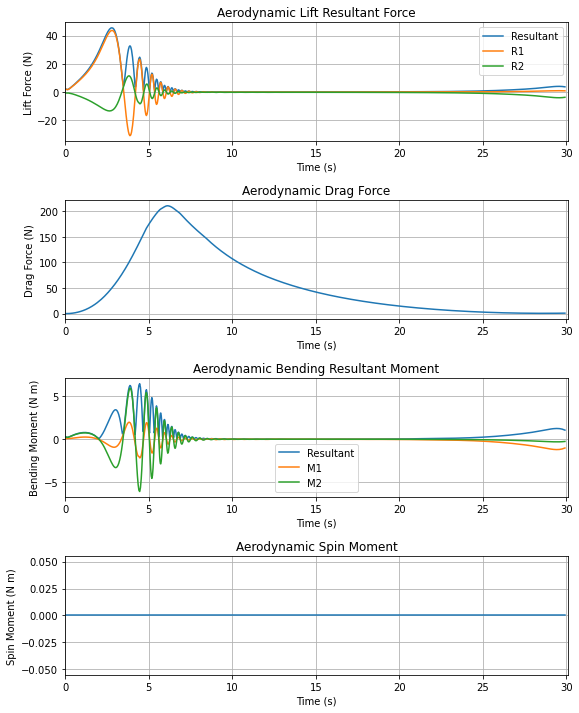



Trajectory Energy Plots



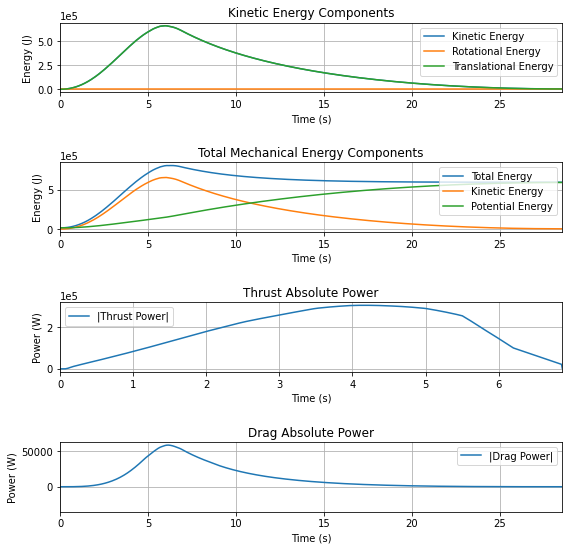



Trajectory Fluid Mechanics Plots



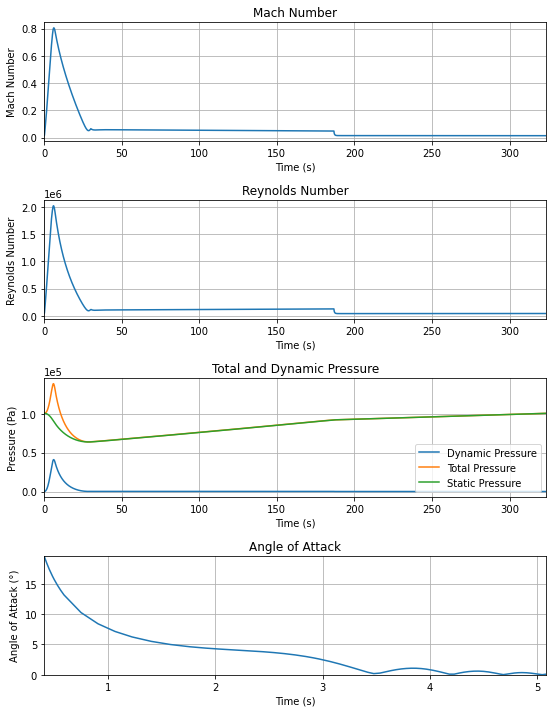



Trajectory Stability and Control Plots



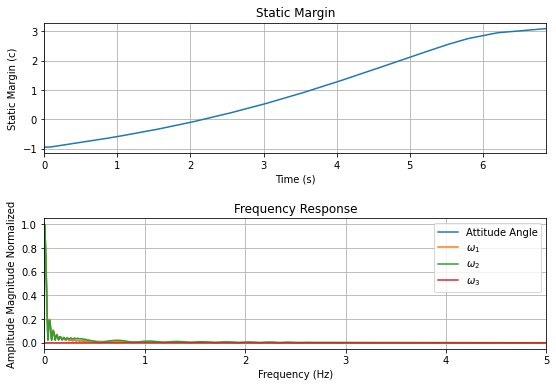

In [24]:
TestFlight = Flight(rocket=Calisto, environment=Env, inclination=85, heading=0)
TestFlight.allInfo()